<a href="https://colab.research.google.com/github/JoseManuel1007/Proyecto1/blob/main/solar_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== MENÚ PRINCIPAL ===
1) Calcular posición del sol (altitud y azimut) para una hora y ubicación dadas
2) Simular irradiancia y producción FV durante un día completo
Seleccione una opción (1 o 2): 2
Ingrese latitud en decimales (ej: 40.4168): 6.245
Ingrese longitud en decimales (ej: -3.7038): -75.57151
Ingrese fecha (YYYY-MM-DD): 2020-09-05
Ingrese inclinación del panel en grados (ej: 30): 30
Ingrese azimut del panel en grados (ej: 180 sur): 180
Offset horario respecto a UTC (ej: -5): -5
Energía total generada el 2020-09-05: 2.06 kWh
📄 CSV guardado en: /content/sim_20200905.csv


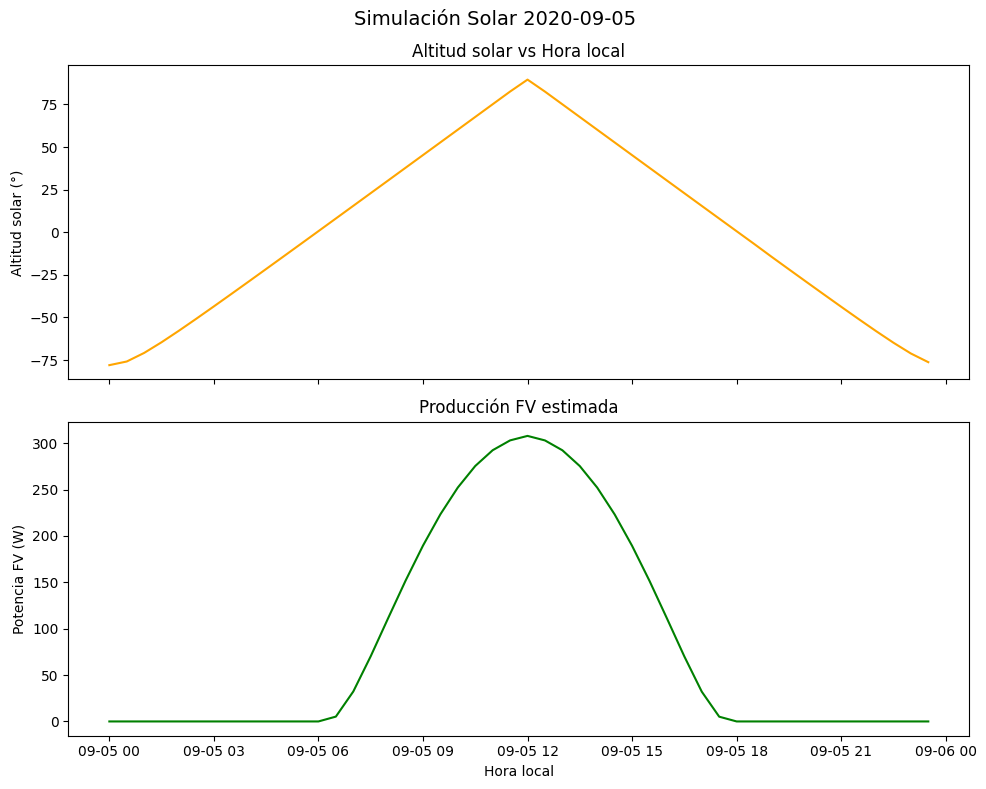

✅ Guardada: /content/graficas_2020-09-05/altitud_vs_hora.png
✅ Guardada: /content/graficas_2020-09-05/azimut_vs_hora.png
✅ Guardada: /content/graficas_2020-09-05/irradiancia_vs_hora.png
✅ Guardada: /content/graficas_2020-09-05/potencia_vs_hora.png
✅ Guardada: /content/graficas_2020-09-05/energia_acumulada.png


In [2]:
import numpy as np, pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

# ------------------------------
# Funciones de cálculo solar
# ------------------------------
def day_of_year(dt): return dt.timetuple().tm_yday

def declination_cooper(n):
    return np.deg2rad(23.45 * np.sin(np.deg2rad(360.0 * (284 + n) / 365.0)))

def equation_of_time_minutes(n):
    B = np.deg2rad(360.0 * (n - 81) / 364.0)
    return 9.87 * np.sin(2*B) - 7.53 * np.cos(B) - 1.5 * np.sin(B)

def local_solar_time_hours_from_utc(dt_utc, lon):
    n = day_of_year(dt_utc)
    utc_hour = dt_utc.hour + dt_utc.minute/60 + dt_utc.second/3600
    return (utc_hour + lon/15.0 + equation_of_time_minutes(n)/60.0) % 24.0

def solar_alt_az_from_datetime(lat, lon, dt_utc):
    n = day_of_year(dt_utc)
    delta = declination_cooper(n)
    phi = np.deg2rad(lat)
    LST = local_solar_time_hours_from_utc(dt_utc, lon)
    H = np.deg2rad(15.0 * (LST - 12.0))
    sin_alpha = np.sin(delta)*np.sin(phi) + np.cos(delta)*np.cos(phi)*np.cos(H)
    alpha = np.arcsin(np.clip(sin_alpha, -1.0, 1.0))
    cosA = (np.sin(delta) - np.sin(alpha)*np.sin(phi)) / (np.cos(alpha)*np.cos(phi) + 1e-12)
    A = np.arccos(np.clip(cosA, -1.0, 1.0))
    az = 2*np.pi - A if H > 0 else A
    return np.rad2deg(alpha), np.rad2deg(az)

def extraterrestrial_irradiance(n):
    return 1367.0 * (1 + 0.033 * np.cos(np.deg2rad(360 * n / 365.0)))

def simple_atmospheric_DNI(Gon, alt_deg, tau=0.75):
    if alt_deg <= 0: return 0.0
    zen = np.deg2rad(90 - alt_deg)
    m = 1 / (np.cos(zen) + 0.50572 * (6.07995 + np.rad2deg(zen))**-1.6364)
    return float(Gon * (tau**m))

def sun_vector_from_alt_az(alt_deg, az_deg):
    alt, az = np.deg2rad(alt_deg), np.deg2rad(az_deg)
    return np.array([np.cos(alt)*np.sin(az), np.cos(alt)*np.cos(az), np.sin(alt)])

def panel_normal_from_tilt_az(tilt_deg, az_panel_deg):
    if not (0.0 <= tilt_deg <= 180.0):
        raise ValueError("tilt_deg debe estar en [0, 180]")
    tilt, azp = np.deg2rad(tilt_deg), np.deg2rad(az_panel_deg % 360.0)
    return np.array([np.sin(tilt)*np.sin(azp), np.sin(tilt)*np.cos(azp), np.cos(tilt)])

def irradiance_on_tilted_surface(Gon, alt_deg, az_sun_deg, tilt_deg, az_panel_deg,
                                 rho_ground=0.2, tau=0.75, DHI_frac=0.15):
    if alt_deg <= 0: return 0.0, {}
    s = sun_vector_from_alt_az(alt_deg, az_sun_deg)
    n = panel_normal_from_tilt_az(tilt_deg, az_panel_deg)
    if n[2] <= 0.0: return 0.0, {}
    DNI = simple_atmospheric_DNI(Gon, alt_deg, tau=tau)
    cos_zen = np.sin(np.deg2rad(alt_deg))
    GHI = DNI * cos_zen / max(1e-6, (1 - DHI_frac)) if DNI > 0 and cos_zen > 0 else 0.0
    DHI = DHI_frac * GHI
    cos_thetai = float(np.dot(s, n))
    It_dir = max(0.0, DNI * cos_thetai)
    beta = np.deg2rad(tilt_deg)
    It_dif = DHI * (1 + np.cos(beta)) / 2.0
    It_grd = rho_ground * GHI * (1 - np.cos(beta)) / 2.0
    total = max(0.0, It_dir + It_dif + It_grd)
    return float(total), {}

def pv_power_from_irradiance(It, area=1.6, eff=0.18):
    if area <= 0 or not (0 < eff <= 1):
        raise ValueError("Área y eficiencia deben ser válidas.")
    return It * area * eff

def to_utc(dt_local, tz_offset_hours):
    return dt_local - timedelta(hours=tz_offset_hours)

# ------------------------------
# Simulación de un día completo
# ------------------------------
def simulate_day(lat, lon, date_local, tilt_deg, az_panel_deg,
                 tz_offset_hours, area=1.6, eff=0.18, step_minutes=30):
    rows = []
    for h in range(24):
        for m in range(0,60,step_minutes):
            dt_local = datetime(date_local.year, date_local.month, date_local.day, h, m)
            dt_utc = to_utc(dt_local, tz_offset_hours)
            alt, az = solar_alt_az_from_datetime(lat, lon, dt_utc)
            Gon = extraterrestrial_irradiance(day_of_year(dt_utc))
            It, _ = irradiance_on_tilted_surface(Gon, alt, az, tilt_deg, az_panel_deg)
            P = pv_power_from_irradiance(It, area, eff)
            rows.append([dt_local, alt, az, It, P])
    df = pd.DataFrame(rows, columns=["datetime_local","alt_deg","az_deg","Irradiance_Wm2","Power_W"])
    return df

# ------------------------------
# Visualización en pantalla
# ------------------------------
def plot_results(df, fecha):
    fig, axes = plt.subplots(2,1, figsize=(10,8), sharex=True)
    axes[0].plot(df["datetime_local"], df["alt_deg"], color="orange")
    axes[0].set_ylabel("Altitud solar (°)")
    axes[0].set_title("Altitud solar vs Hora local")
    axes[1].plot(df["datetime_local"], df["Power_W"], color="green")
    axes[1].set_ylabel("Potencia FV (W)")
    axes[1].set_xlabel("Hora local")
    axes[1].set_title("Producción FV estimada")
    plt.suptitle(f"Simulación Solar {fecha.strftime('%Y-%m-%d')}", fontsize=14)
    plt.tight_layout()
    plt.show()

# ------------------------------
# Guardado de gráficas PNG
# ------------------------------
def graficas_solar(df, fecha, lat, lon):
    horas = df["datetime_local"]
    carpeta = f"graficas_{fecha.date()}"
    os.makedirs(carpeta, exist_ok=True)

    # 1. Altitud solar
    fname = os.path.join(carpeta, "altitud_vs_hora.png")
    plt.figure(figsize=(8,5))
    plt.plot(horas, df["alt_deg"], color="orange")
    plt.xlabel("Hora local"); plt.ylabel("Altitud (°)")
    plt.title(f"Altitud solar - {fecha.date()} (Lat: {lat}, Lon: {lon})")
    plt.grid(True); plt.tight_layout()
    plt.savefig(fname); plt.close()
    print("✅ Guardada:", os.path.abspath(fname))

    # 2. Azimut solar
    fname = os.path.join(carpeta, "azimut_vs_hora.png")
    plt.figure(figsize=(8,5))
    plt.plot(horas, df["az_deg"], color="blue")
    plt.xlabel("Hora local"); plt.ylabel("Azimut (°)")
    plt.title(f"Azimut solar - {fecha.date()} (Lat: {lat}, Lon: {lon})")
    plt.grid(True); plt.tight_layout()
    plt.savefig(fname); plt.close()
    print("✅ Guardada:", os.path.abspath(fname))

    # 3. Irradiancia
    fname = os.path.join(carpeta, "irradiancia_vs_hora.png")
    plt.figure(figsize=(8,5))
    plt.plot(horas, df["Irradiance_Wm2"], color="red")
    plt.xlabel("Hora local"); plt.ylabel("Irradiancia (W/m²)")
    plt.title(f"Irradiancia en el panel - {fecha.date()}")
    plt.grid(True); plt.tight_layout()
    plt.savefig(fname); plt.close()
    print("✅ Guardada:", os.path.abspath(fname))

    # 4. Potencia
    fname = os.path.join(carpeta, "potencia_vs_hora.png")
    plt.figure(figsize=(8,5))
    plt.plot(horas, df["Power_W"], color="green")
    plt.xlabel("Hora local"); plt.ylabel("Potencia (W)")
    plt.title(f"Potencia generada - {fecha.date()}")
    plt.grid(True); plt.tight_layout()
    plt.savefig(fname); plt.close()
    print("✅ Guardada:", os.path.abspath(fname))

    # 5. Energía acumulada
    energia_acum = (df["Power_W"] * 0.5).cumsum() / 1000.0  # pasos de 30min = 0.5h
    fname = os.path.join(carpeta, "energia_acumulada.png")
    plt.figure(figsize=(8,5))
    plt.plot(horas, energia_acum, color="purple")
    plt.xlabel("Hora local"); plt.ylabel("Energía (kWh)")
    plt.title(f"Energía acumulada en el día - {fecha.date()}")
    plt.grid(True); plt.tight_layout()
    plt.savefig(fname); plt.close()
    print("✅ Guardada:", os.path.abspath(fname))

# ------------------------------
# Menú principal
# ------------------------------
if __name__ == "__main__":
    print("=== MENÚ PRINCIPAL ===")
    print("1) Calcular posición del sol (altitud y azimut) para una hora y ubicación dadas")
    print("2) Simular irradiancia y producción FV durante un día completo")
    opcion = input("Seleccione una opción (1 o 2): ")

    if opcion == "1":
        lat = float(input("Ingrese latitud en decimales (ej: 40.4168): "))
        lon = float(input("Ingrese longitud en decimales (ej: -3.7038): "))
        fecha_hora = datetime.strptime(input("Ingrese fecha y hora local (YYYY-MM-DD HH:MM): "), "%Y-%m-%d %H:%M")
        tz = float(input("Offset horario respecto a UTC (ej: -5): "))

        dt_utc = to_utc(fecha_hora, tz)
        alt, az = solar_alt_az_from_datetime(lat, lon, dt_utc)
        print(f"Posición solar en {fecha_hora}:")
        print(f" - Altitud: {alt:.2f}°")
        print(f" - Azimut: {az:.2f}°")

    elif opcion == "2":
        lat = float(input("Ingrese latitud en decimales (ej: 40.4168): "))
        lon = float(input("Ingrese longitud en decimales (ej: -3.7038): "))
        fecha = datetime.strptime(input("Ingrese fecha (YYYY-MM-DD): "), "%Y-%m-%d")
        tilt = float(input("Ingrese inclinación del panel en grados (ej: 30): "))
        az_panel = float(input("Ingrese azimut del panel en grados (ej: 180 sur): "))
        tz = float(input("Offset horario respecto a UTC (ej: -5): "))

        df = simulate_day(lat, lon, fecha, tilt, az_panel, tz)
        step_h = (df["datetime_local"].iloc[1] - df["datetime_local"].iloc[0]).seconds / 3600
        energia_diaria_kWh = (df["Power_W"].sum() * step_h) / 1000.0
        print(f"Energía total generada el {fecha.date()}: {energia_diaria_kWh:.2f} kWh")

        fname = f"sim_{fecha.strftime('%Y%m%d')}.csv"
        df.to_csv(fname, index=False, date_format="%Y-%m-%d %H:%M:%S")
        print("📄 CSV guardado en:", os.path.abspath(fname))

        plot_results(df, fecha)
        graficas_solar(df, fecha, lat, lon)

    else:
        print("Opción no válida. Intente de nuevo.")